In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Model building

> disclaimer: Don't haev the final format of the data so I am generating randomized tensor (based on data frame) to see how the system will behave (size, speed, ...)

## Generating datas

In [4]:
# initial dataframe generated with chatgpt since this is a hasstle to do it manually and this is for dummy data

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Generate the first 7 columns with random floats scaled to [0, 1000)
first_seven_columns = np.random.rand(1000, 7) * 1000

# Step 2: Generate the 8th to 12th columns with one random 1 and others 0
class_columns = np.zeros((1000, 5))
for i in range(1000):
    class_columns[i, np.random.randint(0, 5)] = 1

# Step 3: Generate the next 400 columns, with only 18 non-zero values
next_400_columns = np.zeros((1000, 400))
for i in range(1000):
    # Randomly select 18 columns to have non-zero values
    non_zero_indices = np.random.choice(400, 18, replace=False)
    next_400_columns[i, non_zero_indices] = np.random.randn(18) * 1000  # Scale random values

# Step 4: Generate the last column with clustered prices
price_means = [10, 100, 1000, 10000, 100000]
price_column = np.concatenate([np.random.normal(loc=mean, scale=mean*0.1, size=200) for mean in price_means]).reshape(-1, 1)

# Combine all parts into one DataFrame
data = np.hstack([first_seven_columns, class_columns, next_400_columns, price_column])
column_names = [f"col_{i+1}" for i in range(7)] + [f"class_{i+1}" for i in range(5)] + [f"random_{i+1}" for i in range(400)] + ['price']

df = pd.DataFrame(data, columns=column_names)

# Display the DataFrame
print(df)

          col_1       col_2       col_3       col_4       col_5       col_6  \
0    374.540119  950.714306  731.993942  598.658484  156.018640  155.994520   
1    866.176146  601.115012  708.072578   20.584494  969.909852  832.442641   
2    181.824967  183.404510  304.242243  524.756432  431.945019  291.229140   
3    139.493861  292.144649  366.361843  456.069984  785.175961  199.673782   
4    592.414569   46.450413  607.544852  170.524124   65.051593  948.885537   
..          ...         ...         ...         ...         ...         ...   
995  126.464245  842.554501  362.181603  660.469721  470.816419  198.929780   
996   60.683069  413.342460  546.614940  436.046974  748.672175  827.924955   
997   38.812948  194.128770  536.607509  934.822040  834.956775  842.534508   
998  429.447897  470.705947  157.371583   31.068130  946.902899  240.712586   
999   83.379054  928.507752  579.737115  667.036857  911.576887  345.620169   

          col_7  class_1  class_2  class_3  ...  ra

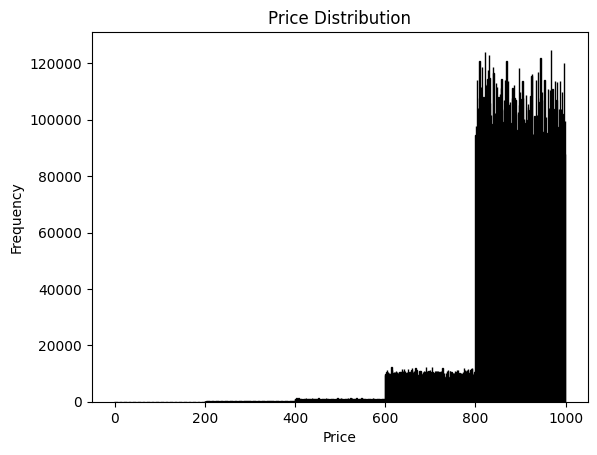

In [6]:
plt.bar(df['price'].index, df['price'].values, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Price Distribution Box Plot')

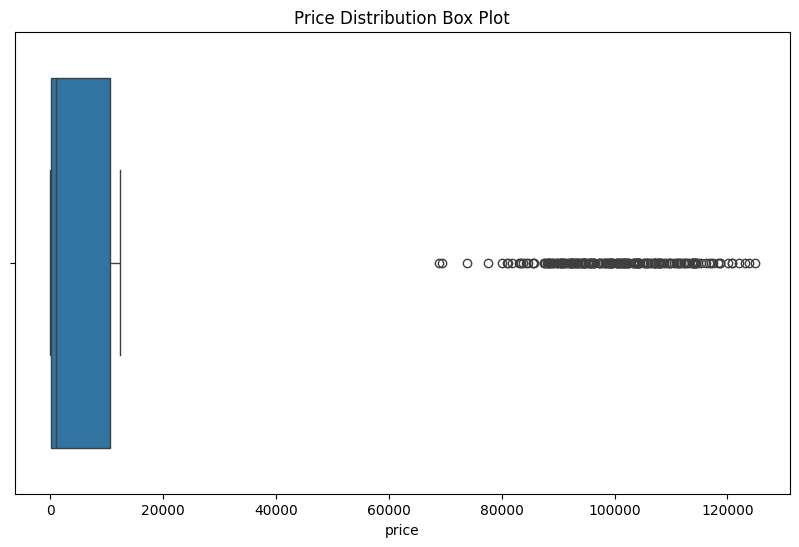

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution Box Plot')

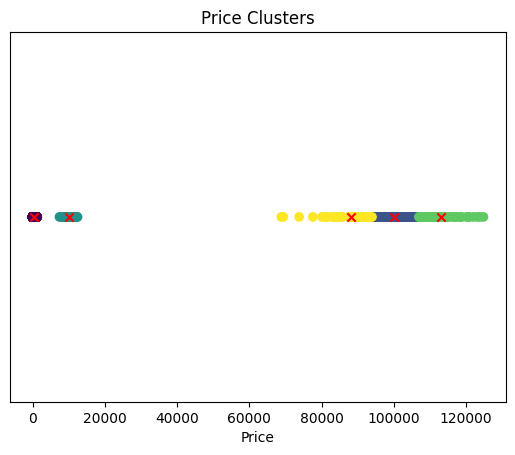

In [12]:
prices_array = df['price'].to_numpy().reshape(-1, 1)

# we assume 4 clusters: S, A, B, C, D
kmeans_with_outlier = KMeans(n_clusters=5, n_init=10, random_state=0)
price_clusters = kmeans_with_outlier.fit_predict(prices_array)

price_cluster_centers = kmeans_with_outlier.cluster_centers_ # for visualization

plt.scatter(prices_array, [0]*len(prices_array), c=price_clusters, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers, [0]*len(price_cluster_centers), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

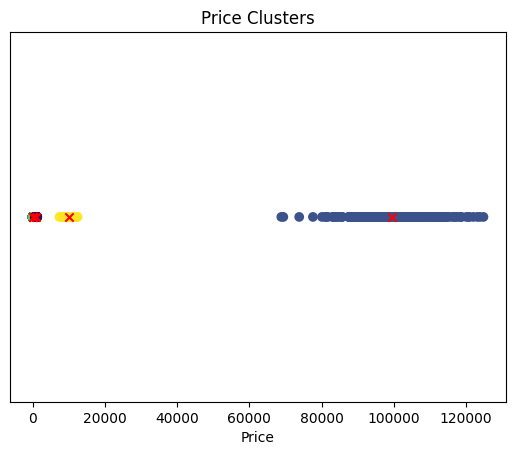

In [16]:
prices_log = np.log1p(prices_array)  # Use log1p to handle zero values
kmeans_with_outlier_log = KMeans(n_clusters=5, n_init=10, random_state=0)
price_clusters_log = kmeans_with_outlier_log.fit_predict(prices_log)

price_cluster_centers_log = kmeans_with_outlier_log.cluster_centers_  # for visualization

price_cluster_centers_original = np.expm1(price_cluster_centers_log)

plt.scatter(prices_array, [0]*len(prices_array), c=price_clusters_log, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers_original, [0]*len(price_cluster_centers_original), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

In [17]:
# adding categories at the end of the df
num_tiers = 5
rows_per_tiers = 200

for i in range(num_tiers):
    df[f'tier_{i+1}'] = 0

for i in range(num_tiers):
    start_index = i * rows_per_tiers
    end_index = start_index + rows_per_tiers
    df.loc[start_index:end_index, f'tier_{i+1}'] = 1

df

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,class_1,class_2,class_3,...,random_397,random_398,random_399,random_400,price,tier_1,tier_2,tier_3,tier_4,tier_5
0,374.540119,950.714306,731.993942,598.658484,156.018640,155.994520,58.083612,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,9.613089,1,0,0,0,0
1,866.176146,601.115012,708.072578,20.584494,969.909852,832.442641,212.339111,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,10.997499,1,0,0,0,0
2,181.824967,183.404510,304.242243,524.756432,431.945019,291.229140,611.852895,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,8.825141,1,0,0,0,0
3,139.493861,292.144649,366.361843,456.069984,785.175961,199.673782,514.234438,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,8.892400,1,0,0,0,0
4,592.414569,46.450413,607.544852,170.524124,65.051593,948.885537,965.632033,1.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,10.619596,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,126.464245,842.554501,362.181603,660.469721,470.816419,198.929780,601.686609,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,81792.450836,0,0,0,0,1
996,60.683069,413.342460,546.614940,436.046974,748.672175,827.924955,771.243074,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,120089.877142,0,0,0,0,1
997,38.812948,194.128770,536.607509,934.822040,834.956775,842.534508,303.208194,0.0,0.0,0.0,...,0.0,0.0,4.021281,0.0,68870.039590,0,0,0,0,1
998,429.447897,470.705947,157.371583,31.068130,946.902899,240.712586,239.948904,0.0,1.0,0.0,...,0.0,0.0,0.000000,0.0,99427.443578,0,0,0,0,1


## Model creation

In [19]:
from dataclasses import dataclass
from typing import Callable

import torch
import torch.nn as nn


### building

In [36]:
@dataclass
class NNLayerConfig:
    in_size: int
    out_size: int
    activation: Callable

@dataclass
class NNCOnfig:
    dropout_rate: float | None
    with_batch_norm: bool
    with_residual: bool
    layers: list[NNLayerConfig]

def Swish():
    '''
    x * 1 / ( 1 + exp(-x) )
    '''
    return lambda x: x * torch.sigmoid(x)    


class ConfigurableBlock(nn.Module):
    def __init__(self, in_size: int, out_size: int, activation: Callable, with_batch_norm: bool = False, with_residual: bool = False):
        super(ConfigurableBlock, self).__init__()
        self.layer = nn.Linear(in_size, out_size)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(out_size)
        self.with_batch_norm = with_batch_norm
        self.with_residual = with_residual
        
        if with_residual and in_size != out_size:
            self.projection = nn.Linear(in_size, out_size)
        else:
            self.projection = None
    
    def forward(self, x):
        if self.with_residual:
            residual = x
            if self.projection:
                residual = self.projection(residual)
        out = self.layer(x)
        if self.with_batch_norm:
            out_norm = self.batch_norm(out)
        out_act = self.activation(out) if not self.with_batch_norm else self.activation(out_norm)
        if self.with_residual:
            out_residual = out_act + residual
        return out_act if not self.with_residual else out_residual

class ConfigurableNN(nn.Module):
    def __init__(self, config: NNCOnfig):
        super(ConfigurableNN, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer in enumerate(config.layers):
            self.layers.append(ConfigurableBlock(layer.in_size, layer.out_size, layer.activation, config.with_batch_norm, config.with_residual))
            if i < len(config.layers) - 1 and config.dropout_rate is not None:
                self.layers.append(nn.Dropout(config.dropout_rate))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

config = NNCOnfig(
    dropout_rate=None,
    with_batch_norm=True,
    with_residual=True,
    layers=[
        NNLayerConfig(412, 256, nn.LeakyReLU),
        NNLayerConfig(256, 256, nn.Tanh),
        NNLayerConfig(256, 128, nn.Tanh),
        NNLayerConfig(128, 64, nn.LeakyReLU),
        NNLayerConfig(64, 5, nn.ReLU),
    ]
)

model = ConfigurableNN(config)

### Training

In [37]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [38]:
input = df.iloc[:, :412].values
output = df.iloc[:, -5:].values

input_tensor = torch.tensor(input, dtype=torch.float32)
output_tensor = torch.tensor(output, dtype=torch.int8)

In [39]:
input_train, input_test, output_train, output_test = train_test_split(input_tensor, output_tensor, test_size=0.3, random_state=666)

train_dataset = TensorDataset(input_train, output_train)
test_dataset = TensorDataset(input_test, output_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [40]:
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [41]:
num_epochs = 10
torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs.float())

        loss = loss_fn(outputs, labels.float())
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float())
            val_loss += loss_fn(outputs, labels.float()).item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(test_loader)}')

Epoch 1/10, Validation Loss: 98.7154541015625
Epoch 2/10, Validation Loss: 29.85784568786621
Epoch 3/10, Validation Loss: 12.539298057556152
Epoch 4/10, Validation Loss: 4.995299625396728
Epoch 5/10, Validation Loss: 2.6920307636260987
Epoch 6/10, Validation Loss: 1.8510241985321045
Epoch 7/10, Validation Loss: 1.409793782234192
Epoch 8/10, Validation Loss: 1.2067734718322753
Epoch 9/10, Validation Loss: 1.0828965187072754
Epoch 10/10, Validation Loss: 0.9752889513969422
